# nonlinear neural network models

Linear models are good and all, but the real *power* of neural networks is in their capacity to approximate nearly *any* nonlinear function.

The original mathematical proof of the "universal approximation theorem" for neural networks is, unfortunately, behind a pay-wall, but a copy of the paper is [here](https://github.com/bryankolaczkowski/ALS3200C/blob/main/hornik1989.pdf). The main conclusion of the paper is: "standard multilayer feed-forward network architectures using arbitrary [activation] functions can approximate virtually any function of interest to any desired degree of accuracy, provided sufficiently many hidden units are available."

So, to approximate (nearly) *any* arbitrary nonlinear function, all we need is:

* a neural network with some non-linear activation function
* "sufficiently many hidden units"

So, what's a "hidden unit"? 

In neural networks, there are two layers that are 'exposed' to the outside world: the *input* layer and the *output* layer. All *other* layers in the network are called "hidden", because we can't 'see' them, directly.

The figure below shows a general 'feed-forward' neural network with two "hidden" layers (yellow), in addition to an input layer (red) and an output layer (teal). The input data and output response is shown in gray.

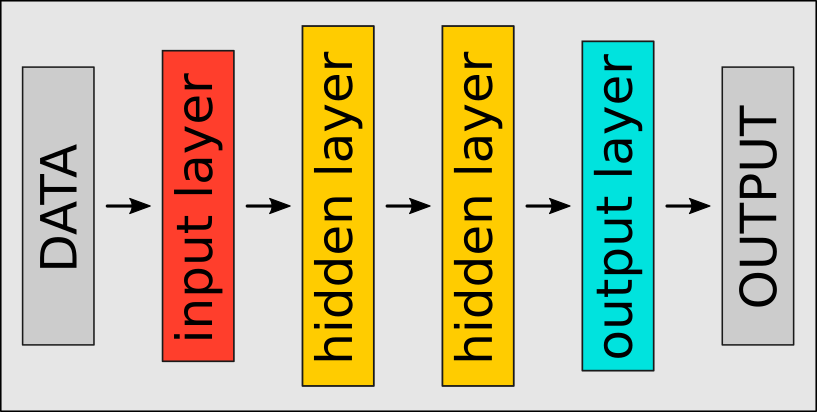

A *linear* neural network has a single layer, which is *both* the input *and* the output layer, so a linear model has *no* hidden layers and isn't a universal function approximator (good thing, too, it's *supposed* to be linear!).

The following figure shows a schematic of a general 'linear' neural network, with a single input/output layer.

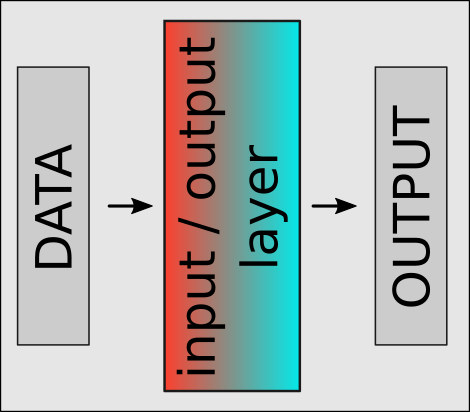

Similarly, a neural network with two layers has an input and an output layer, but *no hidden layers*, so it doesn't fit the criteria for universal approximation. This is shown in the figure below.

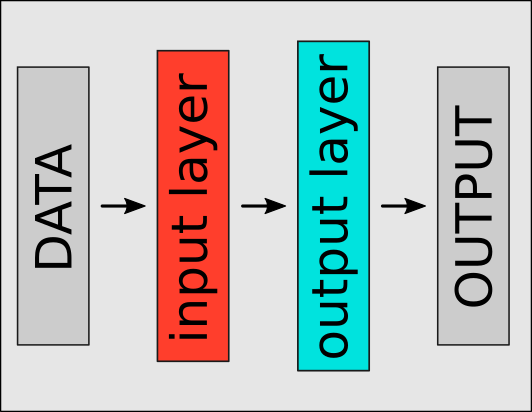

So, to approximate an arbitrary nonlinear function, we need a neural network with *at least* three layers: an input layer, an output layer and at least one "hidden" layer, inbetween.

We *also* need to use non-linear activations between the layers, or else our model will 'collapse' into a simple linear model! At a *minimum*, we'd need non-linear activations after the input layer and after *each* of the hidden layers in the network; we can leave the output layer with linear activation, if we'd like.

The following figure shows a neural network with three layers, including the input (red), output (teal) and a single hidden (yellow) layer. Non-linear activations (green) have been applied to the input layer and the hidden layer. The output layer does not have a non-linear activation, in this case.

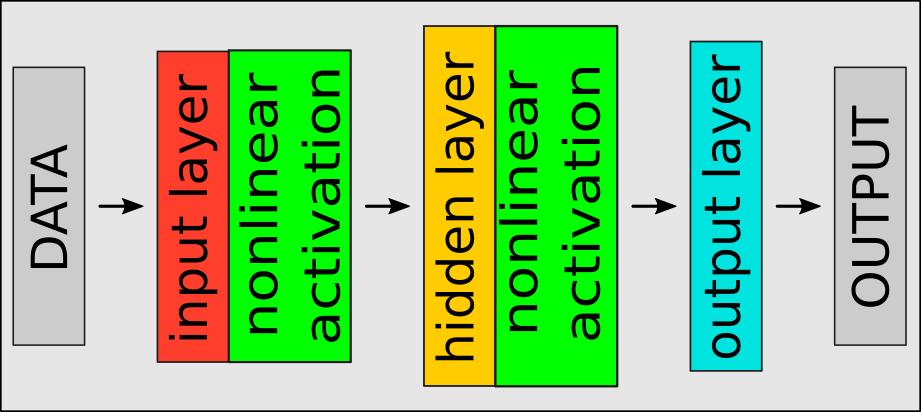


The simple network in the figure above is a *candidate* for universal function approximation, privided "sufficiently many hidden units are available".

How do we know when we have "sufficiently many hidden units"?

In practice, we don't.

Unfortunately, like many mathematical proofs, the universal function approximation theorem for neural networks only tells us that, given an arbitrary function we'd like to approximate to a specified level of accuracy, there *exists* a feed-forward neural network that *can* approximate that function, to our desired level of accuracy. The theorem does *not* offer much guidance as to how to *construct* the neural network!

*Except*, we know that we'll need to use nonlinear activations (any nonlinear activation function should do), and we are likely going to need more than one neuron (aka, "unit") in the hidden layer (we might also want to use more than one hidden layer).

## fitting a neural network to nonlinear data

With that guidance from the mathematicians, let's start building some nonlinear neural networks!

While we don't actually *need* any data to build a neural network, we *will* need some nonlinear data to *fit* our nonlinear neural-network model and *examine* the reliability of the model fit.

So, first we need to simulate some data according to a nonlinear model.

For now, we'll just simulate some very simple polynomial data in one dimension. While polynomials are pretty *simple* nonlinear functions, they are widely used as models to study nonlinear model fitting, and they can actually be a bit tricky to model using neural networks.

One of the 'simplest' nonlinear polynomials is the degree-2 polynomial

    y = m * x**2 + b

which looks like a linear model, except we are "squaring" the explanatory variable, x. Here, "x**2" just means 'raise x to the power 2'.

We can use scikit-learn's "make_regression" function (with a little transformation) to simulate training data from our simple degree-2 polynomial, wich has the characterisic "U"-shape.

In [ ]:
import sklearn.datasets
import matplotlib.pyplot as plt

x,y = sklearn.datasets.make_regression(n_samples=100,
                                       n_features=1,
                                       bias=0.0,
                                       noise=10.0,
                                       random_state=102218)
# transform linear data to polynomial
y = (y/200.0)**2 - 0.5

plt.scatter(x,y, marker='o')

The training data looks pretty 'polynomial'.

Let's start by just fitting a simple linear model to these data, to see how 'good' we can get it. We'll use the exact same tensorflow code as before.

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, input_shape=[1]))
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())
model.summary()

data = tf.data.Dataset.from_tensor_slices((x,y)).batch(10)
model.fit(data, epochs=100)

y_hat = model.predict(x)

plt.scatter(x,y, marker='o')
plt.scatter(x,y_hat, marker='+')

Looking at the plot shows us that the linear model is a *very* poor fit for this data. The residuals show significant 'trends' throughout the range of x-values (they are highly positive at the ends, and negative in the middle!), and they are often very 'large' (in absolute value).

We expect this linear model to be a poor fit to our polynomial data, but it was worth it to check.

Let's fix this problem by making our neural network model nonlinear!

We'll start by building a *very* simple nonlinear model with only two network layers (ie, *no* hidden layers, just input and output layers). While this simple nonlinear network is *not* guaranteed to be a 'universal function approximator', we don't necessarily need our neural network to be 'universal' in this case; we just need it to approximate a simple polynomial.

Remember that, if we don't include a nonlinear activation function after the input layer, we *won't* have a nonlinear model; the network will 'collapse' to a simple linear model.

Let's start by just building a 2-layer neural network, with 1 neuron ("unit") per layer. We'll ignore nonlinear activations for now.

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, input_shape=[1]))
model.add(tf.keras.layers.Dense(units=1))
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())

model.summary()

As the model summary shows, this model has two layers (network "depth" is 2). Each layer consists of a single densely-connected neuron unit (layer "width" is 1). There are 2 "trainable" parameters in each layer (the slope and bias of the linear model), for a total of 4 trainable parameters in the model.

Without nonlinear activations, this 2-layer model will 'collapse' into a simple linear model, which we can confirm by fitting it to our polynomial data.

In [ ]:
data = tf.data.Dataset.from_tensor_slices((x,y)).batch(10)
model.fit(data, epochs=100)

y_hat = model.predict(x)

plt.scatter(x,y, marker='o')
plt.scatter(x,y_hat, marker='+')

The final loss value of the fitted model (0.0358 in my case) is almost *exactly* the same as the single-layer linear model's mean-squared error loss (which was 0.0359 for me), and the plot of the predicted y_hat values (orange +) *appears* very linear.

XX